# **Stanford Web Graph Analysis**

The Stanford Web Graph represents the website structure of Stanford University, providing a detailed snapshot of how web pages within the Stanford domain are interconnected. The dataset, which can be downloaded from https://networkrepository.com/web-Stanford.php, consists of node IDs representing individual web pages and edges representing hyperlinks between these pages.

This notebook contains the necessary code to process the raw data, transforming it into a format suitable for import into Neo4j. Following the data processing steps, we perform exploratory data analysis (EDA) on the graph to uncover different informations.

After the initial exploration, we delve deeper into two specific questions:
1. Community Analysis: Identifying and analyzing inter-community connections within the graph.
2. Home Page Detection: Identifying the node with the highest probability of being the homepage of the Stanford website. This involves using a combination of graph algorithms.

Through this analysis, we aim to gain a comprehensive understanding of the structural properties of the Stanford Web Graph and answer these targeted questions with deeper insights.

# **Setup**

The Setup section includes the requisite code to initiate the Graph Analysis.

The libraries are installed and importe.
The Neo4j credentials are defined to be used during the analysis.

---
**Libraries Install**

In [ ]:
%pip install neo4j
%pip install scikit-learn
%pip install pandas
%pip install seaborn

---
**Libraries Imports**

In [2]:
from neo4j import GraphDatabase

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

---
**Neo4j Credentials**

In [3]:
# Defines database URI, username and password
URI = "bolt://localhost:7687"
USERNAME = "python"     # Change with your credentials
PASSW = "python_api"    # Change with your credentials

# Specifies the database to use
database = 'stanford'

# **Dataset Processing and Import**

This chapter provides a comprehensive guide to transforming the Stanford raw data into structured formats suitable for database import on Neo4j.

---
**Nodes and Relationships Files Creation**

This section outlines the process of creating the necessary CSV files for importing data into Neo4j from raw data. These files are stored in the 'imports' directory.

In [4]:
def create_node_file(df: pd.DataFrame, file_name: str) -> None:
    """Creates a csv file containing the nodes to be imported into Neo4j database.

    Args:
        df: The input pandas Dataframe containing the raw data.
        file_name: The csv file name.

    Returns:
        None
    """
    # Extracts unique IDs from both columns
    unique_source_ids = df['source'].unique()
    unique_destination_ids = df['destination'].unique()

    # Combines unique IDs and remove duplicates
    all_unique_ids = pd.unique(pd.concat([pd.Series(unique_source_ids), pd.Series(unique_destination_ids)]))

    # Creates a new DataFrame with the unique IDs sorted by IDs
    unique_ids_df = pd.DataFrame(all_unique_ids, columns=['Page_id:ID(Page_id)']).sort_values(by='Page_id:ID(Page_id)')

    # Stores the nodes into a CSV file with name 'file_name'
    unique_ids_df.to_csv(file_name, sep=',', index=False)


def create_relationships_file(df: pd.DataFrame, file_name: str) -> None:
    """Creates a csv file containing the relationships to be imported into Neo4j database.

    Args:
        df: The input pandas Dataframe containing the raw data.
        file_name: The csv file name.

    Returns:
        None
    """
    # Creates a copy of the dataframe
    relationships = df.copy()

    # Changes the columns names to the required format
    relationships.columns = [':START_ID(Page_id)', ':END_ID(Page_id)']
    
    # Stores the relationships into a CSV file with name 'file_name'
    relationships.to_csv(file_name, sep=',', index=False)


# Reads the input file 
stanford_df = pd.read_csv('../data/web-Stanford.mtx', engine='python', sep=' ', dtype=int)

# Creates the csv files required for the data import into Neo4j
# The files are placed inside the 'imports' directory
create_relationships_file(df=stanford_df, file_name='../data/relationships.csv')
create_node_file(df=stanford_df, file_name='../data/nodes.csv')

---
**Data Import Process**

To import the nodes and relationships into Neo4j, we must follow these steps:
1. Create a new Project in Neo4j.
2. Add a local DBMS.
3. Open the terminal from the created DBMS.
4. Replace the file 'neo4j.conf' into the DBMS 'conf' directory with the provided configuration.
5. Copy the previously created csv files (nodes and relationships) into the DBMS 'import' directory.
6. Go to the DBMS 'bin' directory and make sure the 'neo4j-admin' file is executable.
7. Run the following command within the 'bin' directory:<pre><code>./neo4j-admin database import full --nodes=Page=../import/nodes.csv --relationships=HYPERLINK=../import/relationships.csv stanford</code></pre>
8. Start the DBMS and create the DB 'stanford'.
9. Add a new User with admin roles with 'USERNAME' and 'PASSWORD' defined before.

After this process, the DB 'stanford' will have all the nodes and relationships imported.

---
**Creating Index and Constraint**

Indexes are used to improve efficiency; they are accessory data structures that manage data on the secondary memory. Indexes allow to perform the search operation in logarithmic time instead of linear time, increasing the system performance. Neo4j helps enforce data integrity with the use of constraints.

To create an index and a constraint, run the following Cypher query:
<pre><code>CREATE CONSTRAINT FOR (p:Page) REQUIRE p.Page_id IS UNIQUE;</code></pre>

Neo4j has recently implemented this feature:

    "Note that adding a uniqueness constraint on a property will also add an index on that property, so you cannot add such an index separately. Cypher will use that index for lookups just like other indexes. If you drop a constraint and still want an index on the property, you will have to create the index."

---
**Data Graph Schema**

To visualize the graph schema, use the following command:
<pre><code>CALL db.schema.visualization;</code></pre>

The database schema is depicted below:
# ![Home page graph](../img/db_schema.png)

# **Graph Exploratory Data Analysis**

In this section, we delve into the Exploratory Data Analysis (EDA) of the Stanford Web Graph. Our focus will be on examining the graph's characteristics in terms of nodes and connectivity. By analyzing these elements, we aim to uncover the underlying structure and properties of the graph, providing valuable insights into its topology and potential relationships within the data.

---
**Helper Functions**

This section defines 2 functions used during the Graph Exploratory Data Analysis, to simplify the code.

In [4]:
def run_managed_transaction(managed_tx, mode: str):
    """
    Executes a managed transaction on a Neo4j database.

    Args:
        managed_tx: The transaction function to be executed.
        mode: The mode of the transaction, either 'read' or 'write'.

    Returns:
        The result of the transaction execution.

    Raises:
        ValueError: If the mode is not 'read' or 'write'.
    """
    # Creates a connection to the database
    with GraphDatabase.driver(URI, auth=(USERNAME, PASSW)) as driver:
        with driver.session(database=database) as session:
            # Executes the transaction function based on the mode
            if mode == 'read':
                ret = session.execute_read(managed_tx)
            elif mode == 'write':
                ret = session.execute_write(managed_tx)
            else:
                raise ValueError("Invalid mode. Use 'read' or 'write'.")
                
    return ret

In [5]:
def plot_distribution(x_axis: list, y_axis: list, x_label: str, y_label: str, title: str, color: str) -> None:
    """
    Plots a bar distribution with the given x and y axis data.

    Args:
        x_axis: A list of values for the x-axis.
        y_axis: A list of values for the y-axis.
        x_label: The label for the x-axis.
        y_label: The label for the y-axis.
        title: The title of the plot.
        color: The color of the bars.

    Returns:
        None
    """
    plt.figure(figsize=(8, 4))
    plt.bar(x_axis, y_axis, color=color)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

---
**Basic Descriptors**

In this section, we will explore the basic descriptors of the Stanford Web Graph, by projecting the graph and calculating fundamental metrics such as the number of nodes, relationships, and graph density.

In [6]:
def basic_descriptors_tx(tx):
    """
    Projects a graph, retrieves its basic descriptors, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        list: A list containing the node count, relationship count, and density of the projected graph.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('graphDetails', 'Page', {HYPERLINK: {orientation: 'NATURAL'}});
    """)

    # Runs the query to retrieve the data
    results = tx.run("""
        CALL gds.graph.list('graphDetails')
        YIELD nodeCount, relationshipCount, density;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('graphDetails');
    """)

    return [record.values() for record in results][0]


# Executes the managed transaction in read mode
# to retrieve the basic descriptors
descriptors = run_managed_transaction(basic_descriptors_tx, mode='read')

# Stores the returned values
n_nodes = descriptors[0]
n_relationships = descriptors[1]
density = descriptors[2]

# Outputs the graph descriptors
print(f"Number of nodes: {n_nodes}")
print(f"Number of relationships: {n_relationships}")
print(f"Graph density: {round(density, 8)}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('graphDetails');\n    "


Number of nodes: 281903
Number of relationships: 2312497
Graph density: 2.91e-05


The Stanford Web Graph's density has an extremely low value (2.91e-05), indicating that it is very sparse. This is a common trait in web graphs where each node is connected to only a small fraction of other nodes. Sparse graphs often possess interesting properties, such as the formation of communities or clusters.

---
**Nodes Degree**

The degree of a node in a graph is the number of edges that are incident to the node; it can be indegree or outdegree. Various statistics can be computed on node degrees (maximum, minimum, average, ecc.). The degree distribution measures the distribution of the number of connections per node.

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('graphIndegree');\n    "
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('graphOutdegree');\n    "


Mean degree: 8.203
Indegree distribution: {'min': 0, 'max': 38606, 'p90': 10, 'p999': 667, 'p99': 59, 'p50': 2, 'p75': 4, 'p95': 18, 'mean': 8.203165627893283}
Outdegree distribution: {'min': 0, 'max': 255, 'p90': 19, 'p999': 105, 'p99': 53, 'p50': 5, 'p75': 9, 'p95': 31, 'mean': 8.203165627893283}


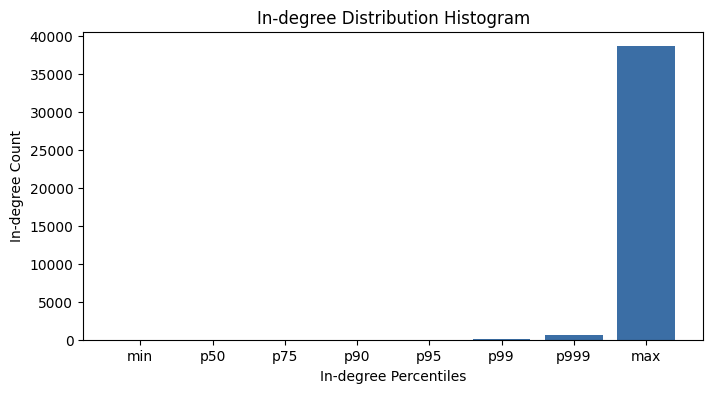

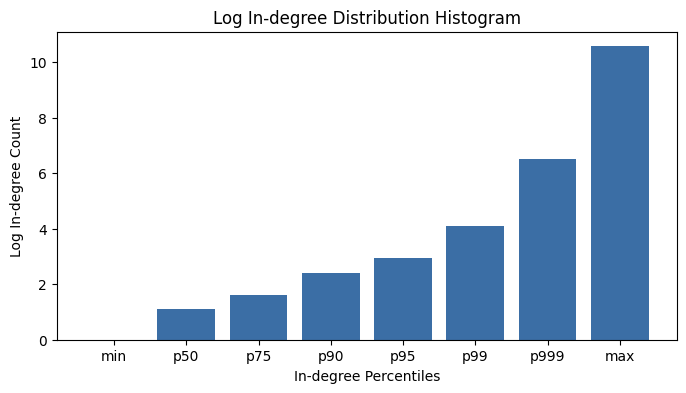

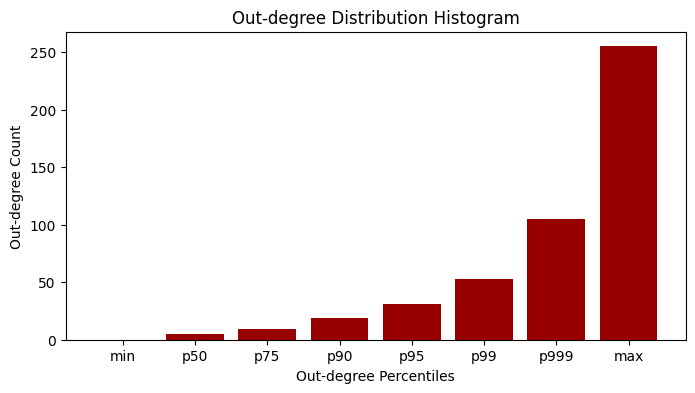

In [7]:
def indegree_distribution_tx(tx):
    """
    Projects a graph, retrieves its indegree distribution, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        dict: A dict containing the percentiles of degree distribution.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('graphIndegree', 'Page', {HYPERLINK: {orientation: 'REVERSE'}});
    """)

    # Runs the query to retrieve the indegree distribution
    results = tx.run("""
        CALL gds.graph.list('graphIndegree')
        YIELD degreeDistribution;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('graphIndegree');
    """)

    return [record.values() for record in results][0][0]


def outdegree_distribution_tx(tx):
    """
    Projects a graph, retrieves its outdegree distribution, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        dict: A dict containing the percentiles of degree distribution.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('graphOutdegree', 'Page', {HYPERLINK: {orientation: 'NATURAL'}});
    """)

    # Runs the query to retrieve the outdegree distribution
    results = tx.run("""
        CALL gds.graph.list('graphOutdegree')
        YIELD degreeDistribution;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('graphOutdegree');
    """)

    return [record.values() for record in results][0][0]


# Executes the managed transactions in read mode
# to retrieve indegree and outdegree distributions
in_distr = run_managed_transaction(indegree_distribution_tx, mode='read')
out_distr = run_managed_transaction(outdegree_distribution_tx, mode='read')

# Creates the histogram data
bins = ['min', 'p50', 'p75', 'p90', 'p95', 'p99', 'p999', 'max']
in_degree_values = [in_distr[key] for key in bins]
out_degree_values = [out_distr[key] for key in bins]

# Outputs the mean degree and the 2 distributions
# The mean degree is equal for both indegree and outdegree
# (https://en.wikipedia.org/wiki/Handshaking_lemma - Definitions and statement)
print(f"Mean degree: {round(in_distr['mean'], 3)}")
print(f"Indegree distribution: {in_distr}")
print(f"Outdegree distribution: {out_distr}")

# Plots the indegree distribution
plot_distribution(
    x_axis=bins,
    y_axis=in_degree_values,
    x_label='In-degree Percentiles',
    y_label='In-degree Count',
    title='In-degree Distribution Histogram',
    color='#3b6ea5'
)

# Plots the log values of the indegree distribution
plot_distribution(
    x_axis=bins,
    y_axis=np.log1p(in_degree_values),
    x_label='In-degree Percentiles',
    y_label='Log In-degree Count',
    title='Log In-degree Distribution Histogram',
    color='#3b6ea5'
)

# Plots the outdegree distribution
plot_distribution(
    x_axis=bins,
    y_axis=out_degree_values,
    x_label='Out-degree Percentiles',
    y_label='Out-degree Count',
    title='Out-degree Distribution Histogram',
    color='#990000'
)

Indegree Distribution:

The distribution is highly skewed, with most nodes having few incoming links, and a few nodes having a very high number of incoming links. The presence of a node with 38606 incoming edges suggests the existence of an extremely influential or popular page linked by many other pages. The median (p50) being 2 indicates that half of the nodes are relatively underlinked or don't actually have links.

Outdegree Distribution:

The outdegree distribution is also skewed, but less extreme compared to the indegree distribution. Most nodes link out to a relatively small number of other pages, with the median outdegree being 5. A maximum outdegree of 255 indicates that no single page excessively links to too many other pages.

The graph exhibits a typical power-law distribution commonly seen in web graphs and other real-world networks, with few nodes having high connectivity (both incoming and outgoing) and many nodes having low connectivity. The disparity between the high maximum indegree and relatively low maximum outdegree suggests the presence of a few very important or authoritative nodes (pages) that many other nodes link to, while even the most active nodes in terms of linking out are somewhat restrained in their connections. The mean degree being equal for both indegree and outdegree (8.203) aligns with the principle that in a directed graph, the sum of all indegrees must equal the sum of all outdegrees (https://en.wikipedia.org/wiki/Handshaking_lemma - Definitions and statement).

---
**Triangle Count**

A triangle in a graph is a set of three nodes where each node is connected to the other two, forming a closed loop. In social network analysis, triangles often represent a high level of clustering and are indicative of strong local cohesion. In web graphs, they can indicate groups of webpages that frequently link to each other.

The Triangle Count algorithm counts the number of triangles for each node in the graph. A triangle is a set of three nodes where each node has a relationship to the other two. In graph theory terminology, this is sometimes referred to as a 3-clique.

In [8]:
def total_triangle_count_tx(tx):
    """
    Projects a graph, retrieves its total triangle count, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        int: The number of total triangle in the graph.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('triangleGraph', 'Page', {HYPERLINK: {orientation: 'UNDIRECTED'}});
    """)

    # Runs the query to retrieve the total triangle count
    results = tx.run("""
        CALL gds.triangleCount.stats('triangleGraph')
        YIELD globalTriangleCount;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('triangleGraph');
    """)

    return [record.values() for record in results][0][0]


# Executes the managed transactions in read mode
# to retrieve the total triangle count value
triangle_count = run_managed_transaction(total_triangle_count_tx, mode='read')
print(f"Total number of triangles: {triangle_count}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('triangleGraph');\n    "


Total number of triangles: 11329473


The total number of triangles in the graph is quite high, indicating a significant level of clustering within the graph. In the context of a web graph, the presence of many triangles suggests that is likely to encounter cycles and interconnected clusters of pages.

Despite the overall sparsity of the graph (low density), the high number of triangles indicates pockets of high connectivity.

---
**Average Clustering Coefficient**

The average clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Clustering often indicates the presence of communities or closely related groups of webpages. A clustering coefficient close to 1 indicates that nodes tend to form tightly knit groups with a high density of edges, while a value close to 0 indicates few or no such tightly knit groups.

In [9]:
def average_clustering_coefficient_tx(tx):
    """
    Projects a graph, retrieves its average clustering coefficient, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        float: The graph's average clustering coefficient.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('clusteringGraph', 'Page', {HYPERLINK: {orientation: 'UNDIRECTED'}});
    """)

    # Runs the query to retrieve the average clustering coefficient
    results = tx.run("""
        CALL gds.localClusteringCoefficient.stats('clusteringGraph')
        YIELD averageClusteringCoefficient;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('clusteringGraph');
    """)

    return [record.values() for record in results][0][0]


# Executes the managed transactions in read mode
# to retrieve the average clustering coefficient
avg_cluster_coef = run_managed_transaction(average_clustering_coefficient_tx, mode='read')
print(f"Average clustering coefficient: {round(avg_cluster_coef, 4)}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('clusteringGraph');\n    "


Average clustering coefficient: 0.5976


An average clustering coefficient of 0.5976 indicates that there is a high level of clustering. This means that, on average, if 2 nodes are both neighbors of a third node, there is a 59.76% chance that they are also neighbors of each other.

A high clustering coefficient suggests that the web pages represented in this graph are organized into well-defined clusters or communities. These clusters may represent groups of related or similar pages that frequently link to each other. 

---
**Strongly and Weakly Connected Components**

Strongly Connected Components are subgraphs where there is a directed path from any node to every other node in the subgraph (in an SCC, you can reach any node from any other node following the directed edges).

Weakly Connected Components are subgraphs where there is an undirected path between any two nodes, regardless of the direction of the edges.

SCCs and WCCs are crucial in understanding the core structure of a directed graph,

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('sccGraph');\n    "
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('wccGraph');\n    "


Mean number of nodes per SCC: 9.424
Nodes in largest SCC: 150532 (0.534)
SCC distribution:
{'min': 1, 'p5': 1, 'max': 150532, 'p999': 450, 'p99': 66, 'p1': 1, 'p10': 1, 'p90': 2, 'p50': 1, 'p25': 1, 'p75': 1, 'p95': 8, 'mean': 9.423781506986694}

Mean number of nodes per WCC: 772.337
Nodes in largest WCC: 255265 (0.906)
WCC distribution:
{'min': 2, 'p5': 2, 'max': 255265, 'p999': 255265, 'p99': 628, 'p1': 2, 'p10': 2, 'p90': 261, 'p50': 15, 'p25': 5, 'p75': 64, 'p95': 400, 'mean': 772.3369863013698}


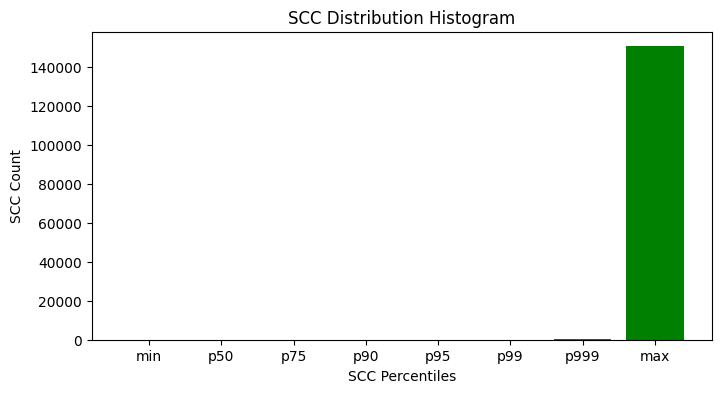

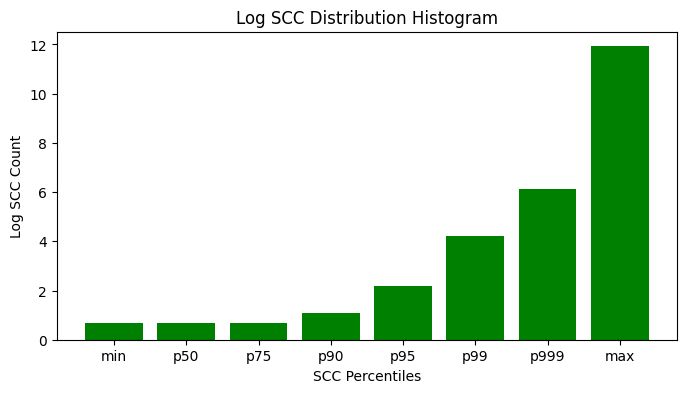

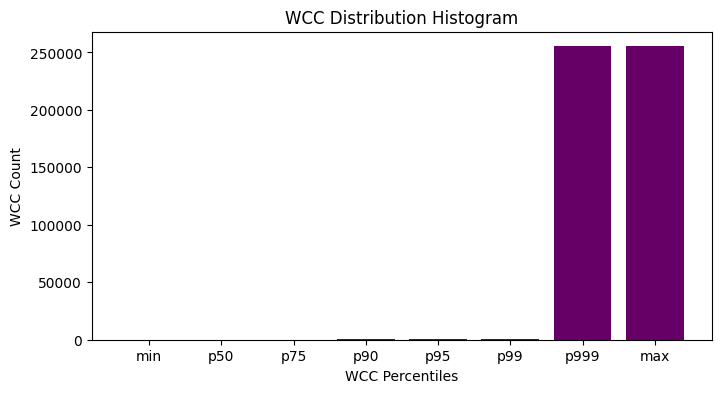

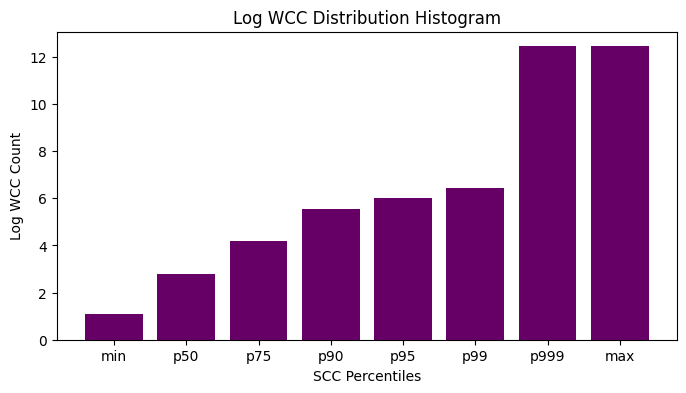

In [10]:
def scc_distribution_tx(tx):
    """
    Projects a graph, retrieves its SCC distribution, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        dict: A dict containing the percentiles of SCC distribution.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('sccGraph', 'Page', {HYPERLINK: {orientation: 'NATURAL'}});
    """)

    # Runs the query to retrieve the SCC distribution
    results = tx.run("""
        CALL gds.scc.stats('sccGraph')
        YIELD componentDistribution;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('sccGraph');
    """)

    return [record.values() for record in results][0][0]


def wcc_distribution_tx(tx):
    """
    Projects a graph, retrieves its WCC distribution, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        dict: A dict containing the percentiles of WCC distribution.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('wccGraph', 'Page', {HYPERLINK: {orientation: 'NATURAL'}});
    """)

    # Runs the query to retrieve the WCC distribution
    results = tx.run("""
        CALL gds.wcc.stats('wccGraph')
        YIELD componentDistribution;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('wccGraph');
    """)
    
    return [record.values() for record in results][0][0]


# Executes the managed transactions in read mode
# to retrieve SCC and WCC distributions
scc_distr = run_managed_transaction(scc_distribution_tx, mode='read')
wcc_distr = run_managed_transaction(wcc_distribution_tx, mode='read')

# Creates the histogram data
scc_values = [scc_distr[key] for key in bins]
wcc_values = [wcc_distr[key] for key in bins]

# Outputs the retrieved data
print(f"Mean number of nodes per SCC: {round(scc_distr['mean'], 3)}")
print(f"Nodes in largest SCC: {scc_distr['max']} ({round(scc_distr['max'] / n_nodes, 3)})")
print(f"SCC distribution:\n{scc_distr}")

print(f"\nMean number of nodes per WCC: {round(wcc_distr['mean'], 3)}")
print(f"Nodes in largest WCC: {wcc_distr['max']} ({round(wcc_distr['max'] / n_nodes, 3)})")
print(f"WCC distribution:\n{wcc_distr}")

# Plots the SCC distribution
plot_distribution(
    x_axis=bins,
    y_axis=scc_values,
    x_label='SCC Percentiles',
    y_label='SCC Count',
    title='SCC Distribution Histogram',
    color='#008000'
)

# Plots the log values of the SCC distribution
plot_distribution(
    x_axis=bins,
    y_axis=np.log1p(scc_values),
    x_label='SCC Percentiles',
    y_label='Log SCC Count',
    title='Log SCC Distribution Histogram',
    color='#008000'
)

# Plots the WCC distribution
plot_distribution(
    x_axis=bins,
    y_axis=wcc_values,
    x_label='WCC Percentiles',
    y_label='WCC Count',
    title='WCC Distribution Histogram',
    color='#660066'
)

# Plots the log values of the WCC distribution
plot_distribution(
    x_axis=bins,
    y_axis=np.log1p(wcc_values),
    x_label='SCC Percentiles',
    y_label='Log WCC Count',
    title='Log WCC Distribution Histogram',
    color='#660066'
)

The mean number of nodes per SCC is 9.424, indicating that most SCCs are relatively small (with 90% of them having 2 or less nodes). However, the largest SCC contains 150532 nodes, which is about 53.4% of the total nodes in the graph, suggesting the presence of a giant strongly connected component.

The mean number of nodes per WCC is 772.337, which is significantly larger than the average SCC size. This indicates that when considering undirected paths, the graph is more connected. The largest WCC contains 255265 nodes, which is about 90.6% of the total nodes, highlighting the overall connectivity of the graph when direction is ignored.

The data shows that while the graph is relatively sparse in terms of edges, it contains significant clustering and connectivity, with a large proportion of nodes forming a giant component in both directed (SCC) and undirected (WCC) contexts. This structure is typical of many real-world networks, including the web, where a large connected core is surrounded by many smaller, more isolated components.

---

**Problems Encountered**

I wasn't able to compute Betweenness centrality, Closeness centrality, Diameter, and Effective Diameter due to extremely long computation times and limited concurrency from the unlicensed GDS, despite having a high-end CPU.

# **Research Questions**

---
**Community Detection and Connectivity**

From the Exploratory Data Analysis is clear that in the Stanford Web Graph are present different communities, with 1 beeing massive. The following section will perform community detection and analyse the connections between communities.

The first phase of this research involves applying a community detection algorithm. For this purpose, the Louvain algorithm is utilized due to its efficiency and ability to uncover hierarchical community structures. The Louvain algorithm operates in two main steps:
1. Modularity Optimization: Initially, each node is assigned to its own community. The algorithm iteratively moves each node to the community of its neighbor if this move increases the network's modularity.
2. Community Aggregation: Once no more individual moves can increase modularity, each community is considered as a single node, creating a new network where the nodes are these aggregated communities. The process is then repeated on this new network, continuing until modularity can no longer be increased.

To analyze the connections between the detected communities, the edges connecting nodes of different communities are computed. This involves creating an adjacency matrix, which is then visualized as a heatmap, providing a clear and intuitive representation of the inter-community connections. The heatmap allows for the identification of strong connections and potential hierarchical structures within the network, facilitating deeper insights into the network's composition and interaction patterns.

For the louvain algorithm, memory estimation is performed to ensure that the algorithm requires less memory than the limit.

In [11]:
def estimate_louvain_tx(tx):
    """
    Estimate the memory requirements for the Louvain community detection algorithm on a graph.

    This function creates a graph projection using nodes and relationships labeled `Page` and `HYPERLINK`
    respectively, estimates the memory requirements for running the Louvain algorithm, and then drops
    the graph projection.

    Args:
        tx: A transaction object for running Cypher queries against the Neo4j database.

    Returns:
        list: A list containing the estimated node count, relationship count, minimum memory bytes, 
              maximum memory bytes, and required memory for the Louvain algorithm.
    """
    # Projects the graph using Cypher projection and GDS library
    tx.run("""
        MATCH (source:Page)-[r:HYPERLINK]->(target:Page)
        WITH gds.graph.project('louvainGraph', source, target) AS g
        RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels;
    """)

    # Runs the query to estimate the required memory
    results = tx.run("""
        CALL gds.louvain.write.estimate('louvainGraph', { writeProperty: 'Community_id' })
        YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('louvainGraph');
    """)

    return [record.values() for record in results][0]


# Executes the managed transactions in read mode
# to retrieve the required memory to perform the algorithm
estimated_memory = run_managed_transaction(estimate_louvain_tx, mode='read')

print(f"nodeCount: {estimated_memory[0]}, relationshipCount: {estimated_memory[1]}")
print(f"nbytesMin: {estimated_memory[2]} bytesMax: {estimated_memory[3]} requiredMemory: {estimated_memory[4]}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('louvainGraph');\n    "


nodeCount: 281903, relationshipCount: 2312497
nbytesMin: 18082321 bytesMax: 107995592 requiredMemory: [17 MiB ... 102 MiB]


The maximum required memory is 102 MiB, which is less than the maximum available memory.

Now that we are sure that the Luovain algorithm can be executed, the nodes are grouped in communities by applying the algorithm.

In [12]:
def louvain_tx(tx):
    """
    Perform community detection on a graph using the Louvain algorithm.

    This function projects a graph using nodes and relationships labeled `Page` and `HYPERLINK`, 
    performs community detection with the Louvain algorithm, and then drops the projected graph 
    from the catalog.

    The algorithm writes a new property called 'community' on the Neo4j graph, containing the 
    community ID of each node.
    
    Args:
        tx: A transaction object for executing Cypher queries against the Neo4j database.

    Returns:
        list: A list containing the community count and modularity obtained from the Louvain algorithm.
    """
    # Projects the graph using Cypher projection and GDS library
    tx.run("""
        MATCH (source:Page)-[r:HYPERLINK]->(target:Page)
        WITH gds.graph.project('louvainGraph', source, target) AS g
        RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels;
    """)

    # Runs the query to perform community detection
    results = tx.run("""
        CALL gds.louvain.write('louvainGraph', { writeProperty: 'community', maxIterations: 50})
        YIELD communityCount, modularity;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('louvainGraph');
    """)
        
    return [record.values() for record in results][0]



# Executes the managed transactions in write mode
# to create the new property 'Community_id'
ret = run_managed_transaction(louvain_tx, mode='write')

n_communities = ret[0]
modularity = ret[1]

print(f"Number of communities: {n_communities}")
print(f"Modularity: {modularity}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('louvainGraph');\n    "


Number of communities: 1507
Modularity: 0.9038807707946


Now that the communities have been detected and the new property 'Community_id' has been created, it's possible to create the adjacency matrix and plot it with a heatmap to anaylise the connections between communities.

     edges  comm_source  comm_dest
0     3447          251        729
1     3447          729        251
2     3077          251        680
3     3077          680        251
4     2397          251        722
..     ...          ...        ...
115    106          915        251
116    103          680        725
117    103          725        680
118    100          469        722
119    100          722        469

[120 rows x 3 columns]


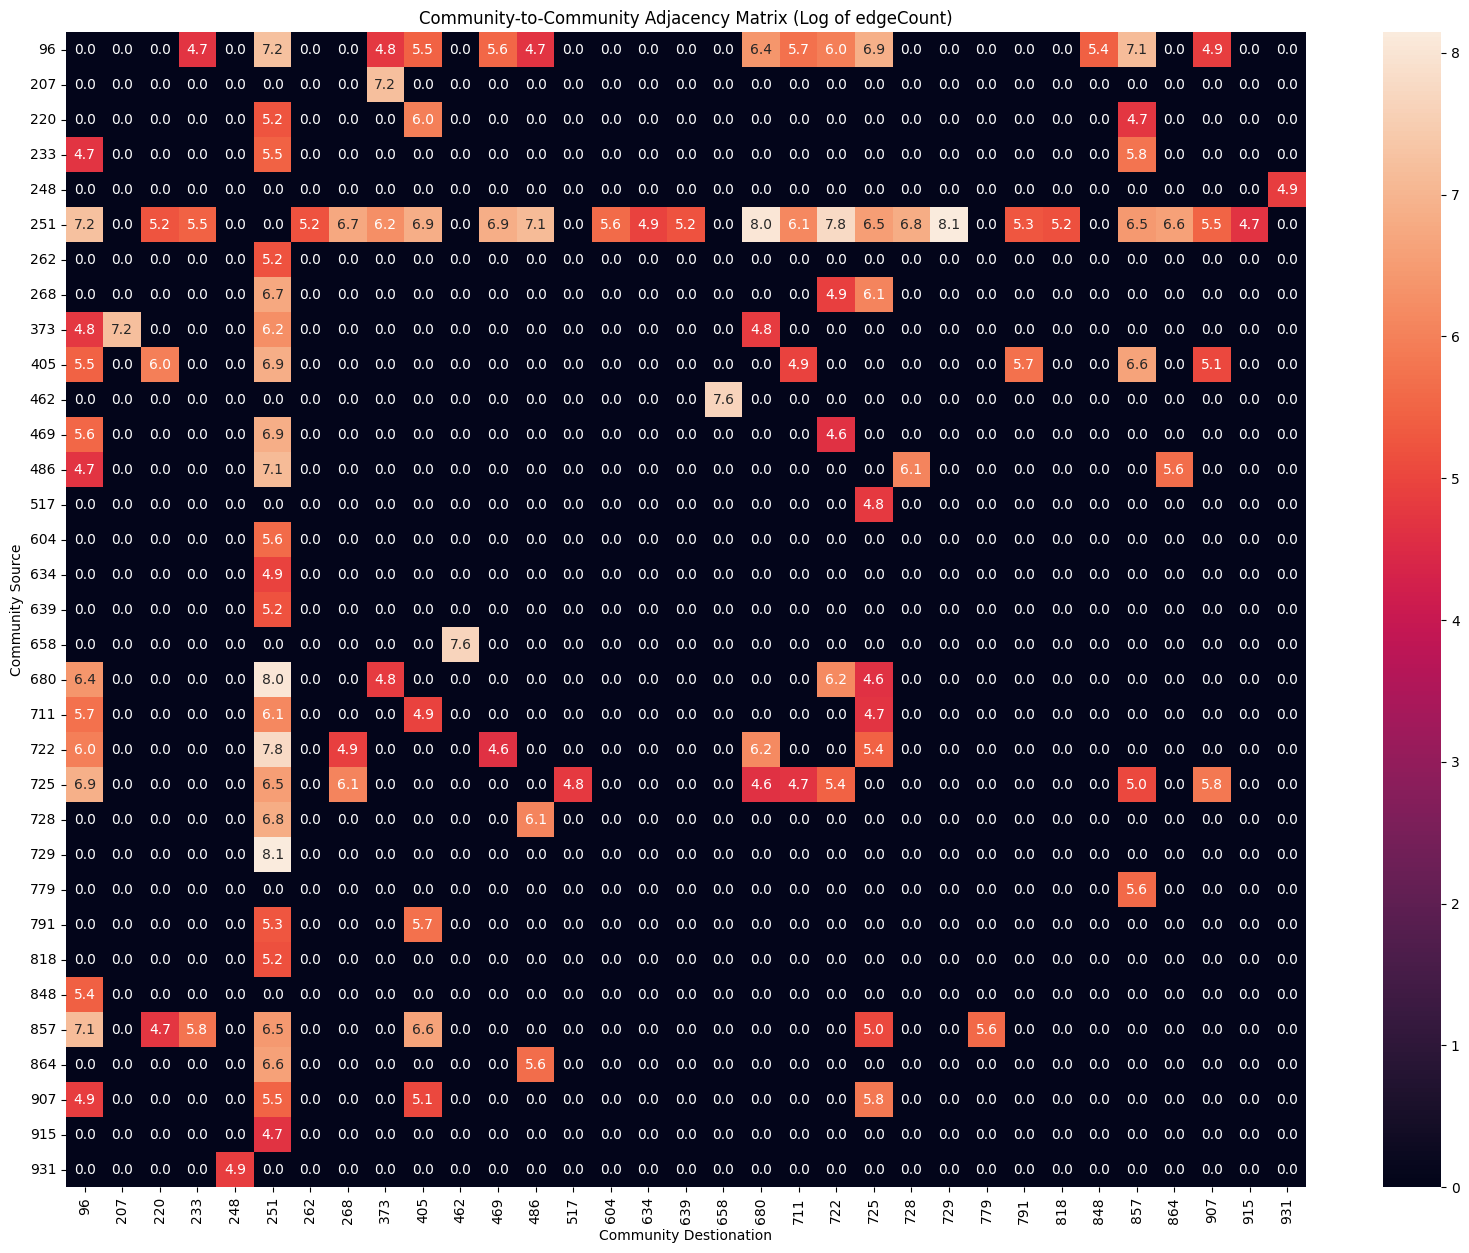

In [13]:
def connectivity_tx(tx):
    """
    Retrieves and processes hyperlink connections between different communities.

    This function runs a Cypher query to find the number of edges between pages
    belonging to different communities in a Neo4j graph database. It filters the results to 
    include only those community pairs with 100 or more edges between them. The results are 
    then collected into an adjacency matrix.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        list of dict: A list containing dictionaries with the following keys:
            - comm_source: The ID of the source community.
            - comm_dest: The ID of the destination community.
            - edges: The count of edges between the source and destination communities.
    """
    results = tx.run("""
        MATCH (p1:Page)-[r:HYPERLINK]-(p2:Page)
        WITH p1.Community_id AS community1, p2.Community_id AS community2, COUNT(r) AS edgeCount
        WHERE community1 <> community2
        AND edgeCount >= 100
        WITH community1, community2, edgeCount
        ORDER BY edgeCount DESC, community1, community2
        RETURN collect({comm_source: community1, comm_dest: community2, edges: edgeCount}) AS adjacencyMatrix;
    """)

    return [record.values() for record in results][0][0]


# Executes the managed transactions in write mode
# to retrieve inter-community connections
ret = run_managed_transaction(connectivity_tx, mode='read')

# Creates a DataFrame from the retrieved data
matrix_df = pd.DataFrame(ret)
print(matrix_df)

# Creates the adjacency matrix from the data
adj_matrix = matrix_df.pivot(index='comm_source', columns='comm_dest', values='edges').fillna(0)

# Plot the adjacency matrix as heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(np.log1p(adj_matrix), annot=True, fmt=".1f", annot_kws={"size": 10})
plt.title("Community-to-Community Adjacency Matrix (Log of edgeCount)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel("Community Destionation")
plt.ylabel("Community Source")
plt.show()

The visual representation of the Stanford Web Graph is reported below (found the image at https://networks.skewed.de/net/stanford_web):
# ![Stanford Web Graph](../img/stanford_web.png)

The adjacency matrix reveals that the connections between communities are sparse, with most communities primarily linked to a single community identified by the ID 251. This community, as identified by the WCC analysis, contains 90.6% of the nodes. This pattern is also evident in the image, which shows a large central community connected to nearly all other communities.

---
**Identifying the Home Page**

The Stanford Web Graph represents the website of Stanford University. Given only the node IDs and the links between nodes, it is valuable to identify the nodes with the highest probability of being the home page.

A home page can be recognized by the following characteristics:
1. A high number of pages link back to the home page.
2. The home page contains numerous useful links directing users to various domains.
3. In a graph representation, the home page should be centrally positioned.
4. The home page is highly valuable, being linked by other pages frequently.

To find the best candidate nodes for the home page, a combination of algorithms is used, with each algorithm targeting a specific property of the home page:
1. High number of incoming links: This can be measured using the indegree metric via the GDS degree algorithm. This algorithm returns the number of incoming edges to each node, allowing the identification of nodes with higher indegree values.
2. High number of outgoing links: This can be measured using the outdegree metric via the GDS degree algorithm. This algorithm returns the number of outgoing edges from each node, helping to identify nodes with higher outdegree values.
3. Central position in the graph: This can be assessed using various algorithms such as Betweenness, Closeness, and HITS. Without being able to compute betweenness and closeness, HITS is a suitable alternative. This link analysis algorithm rates nodes based on two scores, a hub score and an authority score. The authority score estimates the importance of the node within the network, while the hub score estimates the value of its relationships to other nodes.

By scaling and combining the results from these different algorithms, it is possible to identify the best candidate nodes to resemble the home page.

In [14]:
def pagerank_tx(tx):
    """
    Projects a graph, computes the PageRank value for each node, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        list: A list of list, containing the Page_id and its PageRank value.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('pagerankGraph', 'Page', {HYPERLINK: {orientation: 'NATURAL'}});
    """)

    # Runs the query to retrieve the PageRank values
    results = tx.run("""
        CALL gds.pageRank.stream('pagerankGraph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).Page_id AS Page_id, score
        ORDER BY score DESC;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('pagerankGraph');
    """)
    
    return [record.values() for record in results]


# Executes the managed transactions in read mode
# to retrieve the PageRank values
ret = run_managed_transaction(pagerank_tx, mode='read')

# Creates a DataFrame with the resulting data and outputs the first 10 records
pagerank_df = pd.DataFrame(ret, columns=['Page_id', 'PageRank'])
pagerank_df.head(10)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('pagerankGraph');\n    "


,Page_id,PageRank
0,89073,3035.390013
1,226411,2540.346076
2,241454,2294.054707
3,134832,837.292973
4,262860,793.044185
5,234704,707.188243
6,69358,663.081550
7,105607,659.570231
8,136821,659.562656
9,68889,653.449128


In [15]:
def outdegree_tx(tx):
    """
    Projects a graph, computes the outdegree value for each node, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        list: A list of list, containing the Page_id and its outdegree value.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('outdegreeGraph', 'Page', {HYPERLINK: {orientation: 'NATURAL'}});
    """)

    # Runs the query to retrieve the outdegree values
    results = tx.run("""
        CALL gds.degree.stream('outdegreeGraph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).Page_id AS Page_id, score
        ORDER BY score DESC;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('outdegreeGraph');
    """)
    
    return [record.values() for record in results]


# Executes the managed transactions in read mode
# to retrieve the outdegree values
ret = run_managed_transaction(outdegree_tx, mode='read')

# Creates a DataFrame with the resulting data and outputs the first 10 records
outdegree_df = pd.DataFrame(ret, columns=['Page_id', 'Outdegree'])
outdegree_df.head(10)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('outdegreeGraph');\n    "


,Page_id,Outdegree
0,82409,255.0
1,188978,247.0
2,180611,247.0
3,16984,247.0
4,82868,247.0
5,86290,247.0
6,121634,245.0
7,10699,245.0
8,176419,244.0
9,255711,244.0


In [16]:
def indegree_tx(tx):
    """
    Projects a graph, computes the indegree value for each node, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        list: A list of list, containing the Page_id and its indegree value.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('graphIndegree', 'Page', {HYPERLINK: {orientation: 'REVERSE'}});
    """)

    # Runs the query to retrieve the indegree values
    results = tx.run("""
        CALL gds.degree.stream('graphIndegree')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).Page_id AS Page_id, score
        ORDER BY score DESC;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('graphIndegree');
    """)
        
    return [record.values() for record in results]


# Executes the managed transactions in read mode
# to retrieve the indegree values
ret = run_managed_transaction(indegree_tx, mode='read')

# Creates a DataFrame with the resulting data and outputs the first 10 records
indegree_df = pd.DataFrame(ret, columns=['Page_id', 'Indegree'])
indegree_df.head(10)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('graphIndegree');\n    "


,Page_id,Indegree
0,226411,38606.0
1,234704,21920.0
2,105607,19457.0
3,241454,19377.0
4,167295,19003.0
5,198090,18975.0
6,81435,18970.0
7,214128,18967.0
8,38342,18958.0
9,245659,18935.0


In [17]:
def hits_tx(tx):
    """
    Projects a graph, computes the hub value for each node, and then drops the graph in a Neo4j database transaction.

    Args:
        tx: The transaction object for running Neo4j queries.

    Returns:
        list: A list of list, containing the Page_id and its hub value.
    """
    # Projects the graph using GDS library
    tx.run("""
        CALL gds.graph.project('hitsGraph', 'Page', {HYPERLINK: {indexInverse: true, orientation: 'NATURAL'}});
    """)

    # Runs the query to retrieve the hub values
    results = tx.run("""
        CALL gds.hits.stream('hitsGraph', {hitsIterations: 40})
        YIELD nodeId, values
        RETURN gds.util.asNode(nodeId).Page_id AS Page_id, values.hub as hub
        ORDER BY hub DESC;
    """)

    # Drop the projected graph from the catalog
    tx.run("""
        CALL gds.graph.drop('hitsGraph');
    """)
        
    return [record.values() for record in results]


# Executes the managed transactions in read mode
# to retrieve the hub values
ret = run_managed_transaction(hits_tx, mode='read')

# Creates a DataFrame with the resulting data and outputs the first 10 records
hits_df = pd.DataFrame(ret, columns=['Page_id', 'Hub'])
hits_df.head(10)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 9} for query: "\n        CALL gds.graph.drop('hitsGraph');\n    "


,Page_id,Hub
0,97968,0.007256
1,193259,0.007256
2,275047,0.007255
3,102208,0.007255
4,151695,0.007254
5,31061,0.007254
6,194656,0.007254
7,95769,0.007254
8,272199,0.007253
9,95705,0.007253


In [18]:
# Merges DataFrames on 'Page_id'
merged_df = pd.merge(pagerank_df, outdegree_df, on='Page_id', how='outer')
merged_df = pd.merge(merged_df, indegree_df, on='Page_id', how='outer')
merged_df = pd.merge(merged_df, hits_df, on='Page_id', how='outer')

# Creates a MinMaxScaler object and defines the attributes to be scaled
scaler = MinMaxScaler()
columns_to_scale = ['PageRank', 'Outdegree', 'Hub', 'Indegree']

# Scales the attributes 
merged_df[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])

# Calculates the total score by summing the columns
merged_df['Score'] = merged_df['PageRank'] + merged_df['Outdegree'] + merged_df['Indegree'] + merged_df['Hub']

# Sorts the values by score
merged_df = merged_df.sort_values(by='Score', ascending=False)

# Outputs the best nodes to be the home page
home_page_candidates = merged_df.head(10)
home_page_candidates

,Page_id,PageRank,Outdegree,Indegree,Hub,Score
140460,226411,0.836901,0.078431,1.000000,0.000456,1.915789
213397,38342,0.159606,0.105882,0.491064,0.901448,1.658000
269764,89073,1.000000,0.250980,0.395716,0.000006,1.646702
161845,245659,0.095273,0.082353,0.490468,0.901134,1.569228
157174,241454,0.755757,0.250980,0.501917,0.000002,1.508657
191334,272199,0.002008,0.227451,0.000363,0.999525,1.229347
277133,95705,0.002789,0.215686,0.000285,0.999510,1.218270
103623,193259,0.000126,0.176471,0.000130,0.999925,1.176651
194499,275047,0.000120,0.160784,0.000104,0.999836,1.160844
186936,268240,0.037552,0.109804,0.010827,0.999372,1.157555


The resulting Pages are the most likely to be the home page. With the knowledge obtained from the previous question, the community detection and connectivity, it's possible to more additional assumptions. The home page should be part of the biggest central community 251, which is one of the communities that create the backbone of the structure.

In [19]:
def communities_of_pages_tx(tx):
    """
    Retrieves the community IDs for a list of homepage candidate nodes.

    This function runs a Cypher query to find the community ID for each node
    in the provided list of homepage candidates. It matches each node by its
    Page_id and retrieves the corresponding Community_id from the Neo4j graph database.

    Args:
        tx: The Neo4j transaction context.

    Returns:
        list of list: A list of lists, where each inner list contains the Page_id
                      and the corresponding Community_id.
    """
    results = []

    query = """
        MATCH (p:Page {Page_id: $node_id})
        RETURN p.Page_id, p.Community_id;
    """

    for node in home_page_candidates['Page_id']:
        result = tx.run(query, node_id=node)
        results.extend([record.values() for record in result])
    
    return results


# Executes the managed transactions in read mode
# to retrieve the community ids of the nodes
ret = run_managed_transaction(communities_of_pages_tx, mode='read')

# Creates a DataFrame with the community ids
community_df = pd.DataFrame(ret, columns=['Page_id', 'Community_id'])

# Merges the communities to the home page DataFrame
home_page_candidates = pd.merge(home_page_candidates, community_df, on='Page_id', how='outer')
home_page_candidates = home_page_candidates.sort_values(by='Score', ascending=False)
home_page_candidates

,Page_id,PageRank,Outdegree,Indegree,Hub,Score,Community_id
1,226411,0.836901,0.078431,1.000000,0.000456,1.915789,251
7,38342,0.159606,0.105882,0.491064,0.901448,1.658000,251
8,89073,1.000000,0.250980,0.395716,0.000006,1.646702,462
3,245659,0.095273,0.082353,0.490468,0.901134,1.569228,251
2,241454,0.755757,0.250980,0.501917,0.000002,1.508657,658
5,272199,0.002008,0.227451,0.000363,0.999525,1.229347,722
9,95705,0.002789,0.215686,0.000285,0.999510,1.218270,722
0,193259,0.000126,0.176471,0.000130,0.999925,1.176651,722
6,275047,0.000120,0.160784,0.000104,0.999836,1.160844,722
4,268240,0.037552,0.109804,0.010827,0.999372,1.157555,722


The DataFrame clearly shows that the homepage belongs to the major community, and nearly all other candidate nodes are part of communities with the highest number of connections to this primary community. This confirms that the node with the highest score is indeed the homepage.